In [343]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks

# Sampling Hz, timestamps
fs = 2000
stamps = pd.read_csv('timestamps_without_neutral.csv')

# Extract ID (assuming format ID0002) using regular expressions
pattern = r'^ID(\d+)$'
stamps['ID'] = stamps.iloc[:, 0].str.extract(pattern, expand=False).astype(int)

available_idx = stamps['ID'].dropna().astype(int).tolist()

def load_signals(data_dir, available_idx):
  channel1, channel2 = [], []

  for filename in os.listdir(data_dir):    
    # txt only
    if not filename.endswith(".txt"): continue

    # Extract ID from filename (assuming format ID0002)
    match = re.search(r"ID(\d+)", filename)
    if not match: continue

    signal_id = int(match.group(1))

    # nonneutral only
    if signal_id not in available_idx:  continue

    # Read signal data from the text file
    with open(os.path.join(data_dir, filename), 'r') as f:
        for line in f:
            values = [float(val) for val in line.strip().split()]
            channel1.extend(values[:len(values)//2])
            channel2.extend(values[len(values)//2:])
    break

  return signal_id, channel1, channel2

def bandpass_filter(signal, lowcut, highcut, fs = 2000):
  nyq = 0.5 * fs 
  lowcut_normalized = lowcut / nyq
  highcut_normalized = highcut / nyq

  # Design Butterworth filter
  b, a = butter(N=4, Wn=[lowcut_normalized, highcut_normalized], btype='bandpass')
  filtered_signal = filtfilt(b, a, signal)

  return filtered_signal

def RCXB(ecg, icg, fs = 2000):
    # Find R, C, X, and B
    r_peaks, _ = find_peaks(ecg, distance=fs/2.5, height=np.max(ecg)/3)
    c_peaks, _ = find_peaks(icg, distance=fs/2.5, height=np.max(icg)/2)

    d_icg = np.diff(icg)
    b_peaks = []
    x_peaks = []
    # Find X peaks: minimum between each pair of consecutive C peaks
    # Find B peaks: maximum of the derivative between each pair of consecutive C peaks
    for i in range(len(c_peaks) - 1):
      start = c_peaks[i]
      end = c_peaks[i + 1]
      if end > start + 1:  # Ensure there is a range to search within
          
          x_segment = icg[start:end]
          if len(x_segment) > 0:
              x_peak_relative = np.argmax(-x_segment)  # Relative position in the segment
              x_peak = start + x_peak_relative  # Absolute position in the ICG signal
              x_peaks.append(x_peak)    
  
          b_segment = d_icg[start:end]
          if len(b_segment) > 0:
              b_peak_relative = np.argmax(b_segment)  # Relative position in the segment
              b_peak = start + b_peak_relative  # Absolute position in the ICG signal
              b_peaks.append(b_peak)

    return r_peaks, c_peaks, np.array(x_peaks), np.array(b_peaks)

def calculate_vet(b_peaks, c_peaks, x_peaks, fs = 2000):
    vet = []
    for b in b_peaks:
        # Find X peaks that occur after the current B peak
        valid_x_peaks = [x for x in x_peaks if x > b]
        for x in valid_x_peaks:
            # Count the number of C peaks between B and X
            c_between = [c for c in c_peaks if b < c < x]
            if len(c_between) == 1:
                # Calculate VET as the time difference between X and B
                vet.append((x - b)/fs)
                break  # Move to the next B peak after finding a valid X
    return vet

def calculate_co(ecg, icg, fs = 2000): 
  r_peaks, c_peaks, x_peaks, b_peaks = RCXB(ecg, icg)
  if len(r_peaks) > len(c_peaks): r_peaks = r_peaks[1:]

  # Heart rate (bpm)
  # Discard last and first, for first no info
  HR = [ fs * 60 / hr for hr in np.diff(r_peaks[:-1])]

  # Ventricular ejection time (s)
  # Discard last and first c peak - first b and last x never detected
  T = calculate_vet(b_peaks, c_peaks, x_peaks)

  # dZ/dt max (Ohm/min)
  # Discard last and first beat
  dZ_dt_max = icg[c_peaks[1:-1]] - icg[b_peaks[:-1]]

  # Stroke volume (ml)
  SV = T * dZ_dt_max

  # Calculate Cardiac Output
  return SV * HR 

def process(stamps, signal_id, channel1_raw, channel2_raw, fs = 2000):
  channel1 = bandpass_filter(channel1_raw, lowcut=1.0, highcut=40)
  channel2 = bandpass_filter(channel2_raw, lowcut=1.0, highcut=40)

  # Timestamps of signal
  signal_timestamps = stamps[stamps['ID'].isin([signal_id])][['T1', 'T2', 'T3', 'T4']]
  T1, T2, T3, T4 = signal_timestamps.iloc[0]*fs

  stamps = stamps[stamps['ID'] != signal_id]

  # Devide into eras
  ecg_base =  channel1[T1:T2]
  ecg_audio = channel1[T3:T4]
  icg_base =  channel2[T1:T2]
  icg_audio = channel2[T3:T4]

  co_base =  calculate_co(ecg_base, icg_base, fs)
  co_audio = calculate_co(ecg_audio, icg_audio, fs)

  return co_base, co_audio



# Load and preprocess
- Filter the signals
- Split to base and audio
- Plot a segment

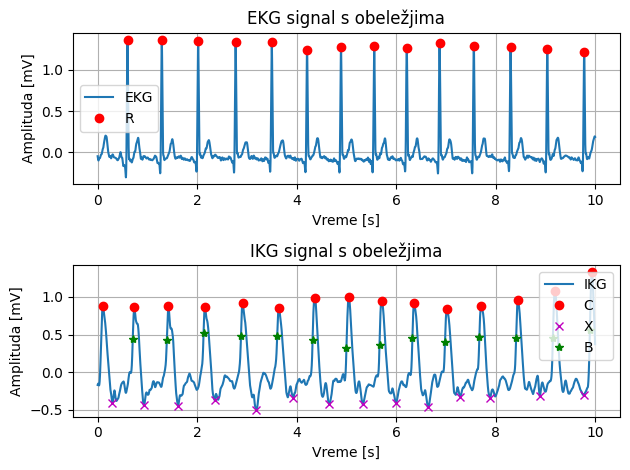

In [322]:
signal_id, channel1_raw, channel2_raw = load_signals("cardiprint_signals", available_idx)
#available_idx.remove(signal_id)
filtered_signals = {}

# ch1: ECG, 1 - 40Hz filtered
# ch2: ICG, 1 - 40Hz filtered, 0.5 - 40Hz not stable
channel1 = bandpass_filter(channel1_raw, lowcut=1.0, highcut=40)
channel2 = bandpass_filter(channel2_raw, lowcut=1.0, highcut=40)

# Timestamps of signal
signal_timestamps = stamps[stamps['ID'].isin([signal_id])][['T1', 'T2', 'T3', 'T4']]
T1, T2, T3, T4 = signal_timestamps.iloc[0]*fs

# Devide into eras
ecg_base =  channel1[T1:T2]
ecg_audio = channel1[T3:T4]
icg_base =  channel2[T1:T2]
icg_audio = channel2[T3:T4]

# Detect feature points
r_peaks, c_peaks, x_peaks, b_peaks = RCXB(ecg_base, icg_base)
# Define the segment to plot
start = 0 * fs  # Start at 10 seconds
duration = 10 * fs  # Duration of 10 seconds
end = start + duration

# Get the time array for the segment
t = np.arange(start, end) / fs

# Get the signal segments
ecg_segment = ecg_base[start:end]
icg_segment = icg_base[start:end]

# Adjust the peak indices to the segment
r_peaks_segment = r_peaks[(r_peaks >= start) & (r_peaks < end)] - start
c_peaks_segment = c_peaks[(c_peaks >= start) & (c_peaks < end)] - start
x_peaks_segment = x_peaks[(x_peaks >= start) & (x_peaks < end)] - start
b_peaks_segment = b_peaks[(b_peaks >= start) & (b_peaks < end)] - start

fig, axs = plt.subplots(2)

# Plot ECG with R peaks
axs[0].plot(t, ecg_segment, label='EKG')
axs[0].plot(t[r_peaks_segment], ecg_segment[r_peaks_segment], 'ro', label='R')
axs[0].set_title('EKG signal s obeležjima')
axs[0].set_xlabel('Vreme [s]')
axs[0].set_ylabel('Amplituda [mV]')
axs[0].legend()
axs[0].grid()

# Plot ICG with C, B and X peaks
axs[1].plot(t, icg_segment, label='IKG')
axs[1].plot(t[c_peaks_segment], icg_segment[c_peaks_segment], 'ro', label='C')
axs[1].plot(t[x_peaks_segment], icg_segment[x_peaks_segment], 'mx', label='X')
axs[1].plot(t[b_peaks_segment], icg_segment[b_peaks_segment], 'g*', label='B')
axs[1].set_title('IKG signal s obeležjima')
axs[1].set_xlabel('Vreme [s]')
axs[1].set_ylabel('Amplituda [mV]')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

# Batch process

Processed signal 1


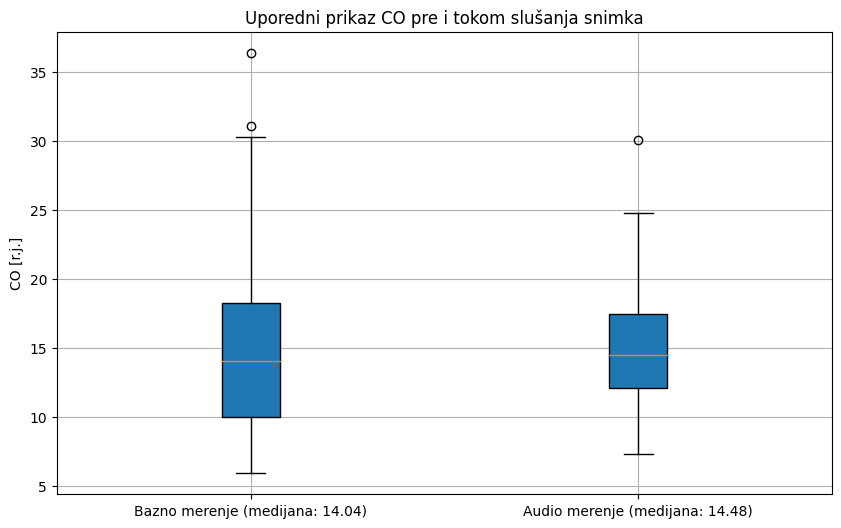

Processed signal 3


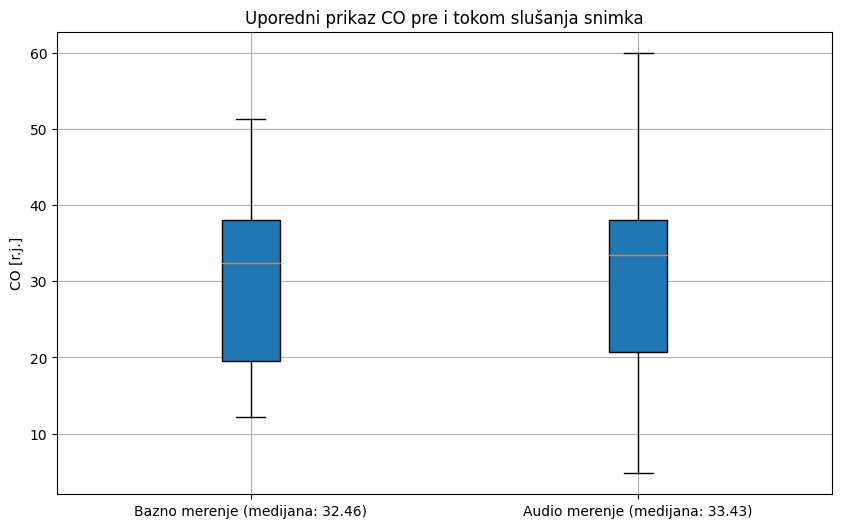

Processed signal 15


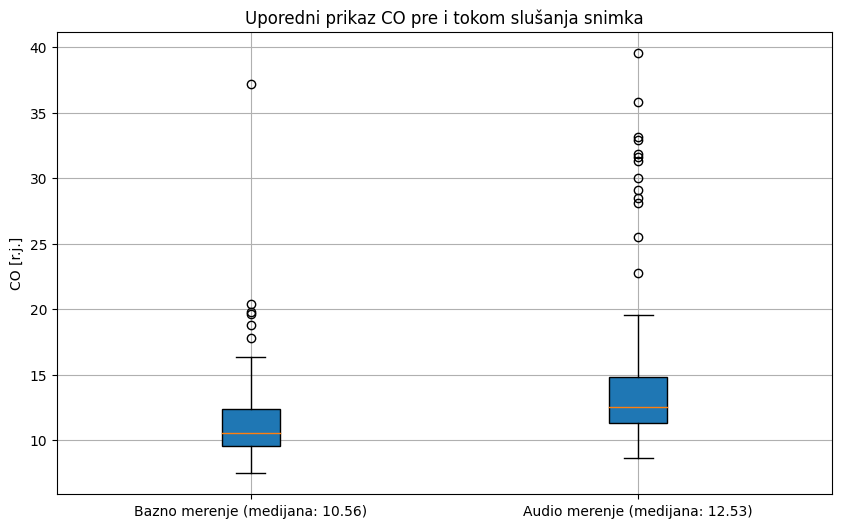

Processed signal 57


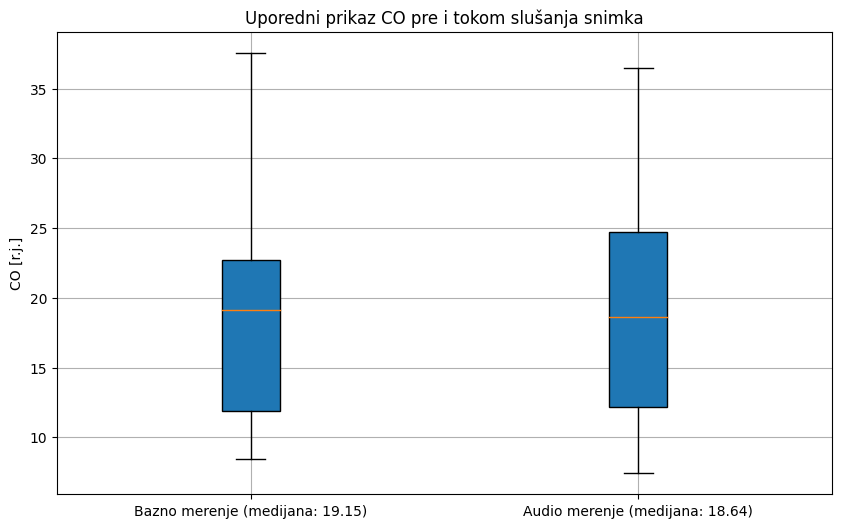

Processed signal 69


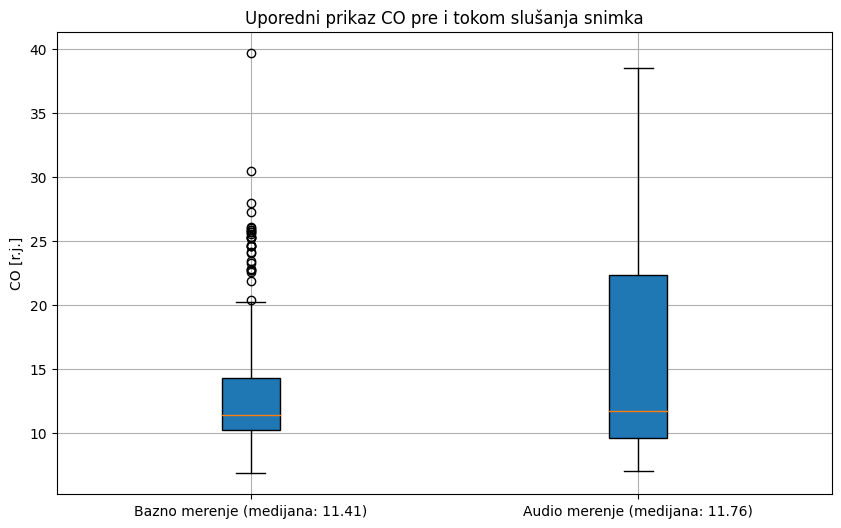

KeyboardInterrupt: 

In [344]:
table = []
while available_idx:
    try:
        # Load and process signals
        signal_id, channel1_raw, channel2_raw = load_signals("cardiprint_signals", available_idx)
        if signal_id in [1, 3, 15, 57, 69]:
            temp_base, temp_audio = process(stamps, signal_id, channel1_raw, channel2_raw, fs = 2000)
            print(f"Processed signal {signal_id}")
            data = [temp_base, temp_audio]

            # Calculate mean values
            mean_base = np.median(temp_base)
            mean_audio = np.median(temp_audio)
            std_base = np.std(temp_base)
            std_audio = np.std(temp_audio)

            table.append([signal_id, 'Bazno', mean_base, std_base])
            table.append([signal_id, 'Audio', mean_audio, std_audio])

            # Create the box plot
            plt.figure(figsize=(10, 6))
            plt.boxplot(data, vert=True, patch_artist=True, labels=[f'Bazno merenje (medijana: {mean_base:.2f})', f'Audio merenje (medijana: {mean_audio:.2f})'])
            plt.title('Uporedni prikaz CO pre i tokom slušanja snimka')
            plt.ylabel('CO [r.j.]')
            plt.grid(True)

            # Show the plot
            plt.show()
        available_idx.remove(signal_id)

    except Exception as e:
        print(f"Error processing signal {signal_id}: {e}")
        available_idx.remove(signal_id)

In [345]:
# Convert the results to a pandas DataFrame
columns = ['Ispitanik', 'Scenario', 'Medijana', 'Standardna Devijacija']
df = pd.DataFrame(table, columns=columns)

# Print the DataFrame in a format that can be easily copied to Word
print(df.to_string(index=False))

 Ispitanik Scenario  Medijana  Standardna Devijacija
         1    Bazno 14.038954               5.463009
         1    Audio 14.478899               4.061821
         3    Bazno 32.463355               9.891414
         3    Audio 33.434934               9.701511
        15    Bazno 10.556254               3.192297
        15    Audio 12.533957               5.794180
        57    Bazno 19.154473               6.228428
        57    Audio 18.637955               7.317504
        69    Bazno 11.407989               5.996091
        69    Audio 11.764037               8.415321
